# Demonstration of music streaming service churn prediction project

### Motivation

* Many products and services are now provided with a subscrition based distribution. 
* This drives an industry need: Utilization of user behavior to understand and predict user retention.
    * Could be used for example to do targeted advertising or revenue prediction

### Problem Statement

Can user demographics and user log data be utilized to predict whether a user is retained within a given period?

### Summary of Key Findings

#### From exploratory analysis:

1) There are about 14 times more retained users than churned. This population imbalance will be important in model building
    
2) Churn users are on average younger than retained users (t-test with p-value~1e-134). This may be due causal factors such as lower income status.
    
3) Retained users are more likely to use auto renew while churn users are more likely to not utilize auto renew.
    
4) On a log-scale, user activity shows a longer tail for retained users indicating that users with high activity are typically retained. Perhaps a variable transformation would make activity a more useful quantity.
    
    
#### From modeling:
1) Currently, model accuracy evaluated via 2-fold cross validation is consistent with the model lumping all users into the retained group.

2) The approaches of undersampling majority population and oversampling minority populations do not seem to improve the preliminary model.

3) The next step should be the calculation of significantly more features. Currently only 20 features are used to build the models. Furthermore, over halff of the features are demographic and/or features aggregated from user log data.  

4) More data was recently made available. Incorporating this may additionally improve the model if population imbalance is less significant in this new data set. 

### Overview

The Document is organized as follows. In Sec. I, I highlight the structure of the dataset. In Sec. II, I provide a demonstration of the preprocessing and feature calculations done using a small subset of the data for demonstration only. In Sec. III, I import the full dataset including features calculated with the demostrated techniques and conduct an exploratory analysis. In Sec. IV I create logistic regression and random forest classification models. A few iterations of the model development are indicated, particularly, a significant population imbalance is found to be present, and will probably be important in a final analysis beyond this rough draft. Finally, in Sec. V, I conclude with a list of items which I think would improve workflow and/or model performance which I will continue to pursue.  

# I. The Dataset

The problem stated above will be addressed in this notebook utilizing the KKBox Music Prediction Challenge Dataset available at https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data. Properties of the dataset are highlighted below.

## Structure of train.csv, members.csv, transactions.csv, and user_logs.csv

Note that the data have already been preprocessed in other notebooks, so this will merely demo a small example.

In [37]:
##Load libraries needed for the analysis in this notebook
import os.path

#Data manipulation libraries
import pandas as pd
from pandas import DataFrame, Series
from datetime import datetime, timedelta
import numpy as np
import sqlite3 as sq3

#For parallelizing user feature calculations 
#Not really needed in this demo but it speeds things up by about a factor of 2 on real calculation.
import multiprocessing
from multiprocessing import Pool

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
from seaborn import heatmap

#Machine learning and stats libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import stats

In [2]:
##Import a sample of the training and members csv files as pandas dataframes
nmax=1e5
traindf=pd.read_csv("train.csv",nrows=nmax)
memberdf=pd.read_csv("members.csv",nrows=nmax)
transactiondf=pd.read_csv("transactions.csv",nrows=nmax)
uselogdf=pd.read_csv("user_logs.csv",nrows=nmax)

### train.csv 
is an ~50MB file that has observations with user names and a binary indicator for if the user churns (drops subscription = 1, retained =0). The full dataset has 992931 observations. It is important to note that there is about a 14:1 ratio of retained to churn users in the training set. This imbalance will guide modeling decisions later on.

In [3]:
traindf.head(n=5)

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


### members.csv 
is an ~400MB file that has observations with user names a numerical indicator for the city which that user is from, gender, numerical indicator for registration method, initial registration date, and expiration date. The full dataset has 5116194 records. Note that not all members in train.csv are available even though members.csv has about 5 times more records.

In [4]:
memberdf.head(n=5)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,0,NaN,9,20150525,20150526
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,0,NaN,4,20161221,20161224
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,0,NaN,4,20160306,20160309
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17,female,4,20161031,20161107
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,0,NaN,4,20170202,20170205


### transactions.csv 
is an ~2GB file that has multiple observations for each user of: numerical identifier for payment method, payment plan days, the plan list price, the actual amount paid, whether the user has elected to auto renew, the date for the transaction, membership expiration date, and finally, wheter or not the user cancelled their membership. (This does not necessarily indicate churn. See e.g. Data Extraction Details at https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data.)

In [5]:
transactiondf.head(n=10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0
5,KN7I82kjY0Tn76Ny95ncqBUVbO7b8AXrOPqZutKpxIM=,21,30,149,149,1,20150930,20151107,0
6,m5ptKif9BjdUghHXXomSezy5ohJiHm85PE13f/3kQaw=,39,30,149,149,1,20150930,20151128,0
7,uQxbyACsPOEkTIrv9jZgoGXelGBW81ZsSZKy9fhj5Z8=,39,30,149,149,1,20150930,20151125,0
8,LUPRfoE2r3WwVWhYO/TqQhjrL/qP6CO+/ORUlr7yNc0=,39,30,149,149,1,20150930,20151222,0
9,pMVjPLgVknaJYm9L0xUwxA2jmhpK7gfhGnsmmwX1mrE=,39,30,149,149,1,20150930,20151118,0


### user_logs.csv 
is an ~30GB file that has multiple observations for each user of: the date for which the observation is made, the number of songs where the user listened to between 0% and 25% of the song (num_25),..., the number of songs for which the user listened to between 98.5% and 100% of the song (num_100), the number of unique songs listened to (num_unq), and total amount of time the service was used for the particular day. Note that this file appears sorted by user and by date, but I don't take this for granted in my analysis. It could speed things up, but taking advantage of this would mean more data management for newly available data which was recently made available (not yet analyzed).

In [6]:
uselogdf.head(n=10)

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029
5,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150702,4,0,1,1,33,10,10021.520
6,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150830,3,1,0,0,4,7,1119.555
7,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20151107,1,0,0,0,4,5,938.022
8,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20160110,2,0,1,0,11,6,3004.068
9,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20160316,9,3,4,1,67,50,18257.661


# II. Preprocessing the data and calculating features:

### Step 1: Merge the member and training data frames, drop registration and expiration dates, and create lookup keys for each user.

The first two steps are cleanup. The last is done because I converted both transactions.csv and user_logs.csv into sqlite databases in a python script (run from the command line on my machine). While this makes the files larger, I took this approach for a couple of reasons:
* The user_logs.csv file is too large to fit into memory. By querying a database I don't have to read the file into memory.
    * I also felt that this was a more easily generalizable framework for data management and updating than the provided csv data given the file size.
* Most importantly, I wanted to begin learning to work with database management systems like SQL 
    * I learned for example the importance of indexing for fast lookups in a medium sized database.

In [7]:
##Merge the data on user name  (i.e. msno) and see what the final dataframe looks like
traindf=pd.merge(traindf,memberdf,on='msno')

##Note there are members in the training set not in the member set. The merge process cleans those up for us.

##Get rid of registration_init_time and expiration_date which will not be used in this rough draft of the project
traindf=traindf.drop(['registration_init_time','expiration_date'],axis=1)

##Generate keys for lookup in user_log database
traindf['key1']=traindf.msno.str[0]
traindf['key2']=traindf.msno.str[1]
traindf=traindf.sort_values(by=['key1','key2']).reset_index(drop=True)
groupedtrain=traindf.groupby(['key1','key2'])
keylist=list(groupedtrain.groups.keys())

traindf.head(n=10)

,msno,is_churn,city,bd,gender,registered_via,key1,key2
0,++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,0,1,0,NaN,7,+,+
1,+2QopJoFmEqb7AMPTLFy9DyUp6fQCbGTqp5jn13uYzw=,1,1,31,female,4,+,2
2,+30E3s3duRnFj5RbqvNUrkfXa/Fsz1YPJaIRJKPaYbY=,0,1,0,NaN,7,+,3
3,+5qnHjPelHKu0ig6ZpApTkphYORmORFAoqyyuvf195g=,1,4,20,male,9,+,5
4,+8fMR768JncJEPNCl+1GmNXU3jYK1xz/8GeLjp+AUsw=,1,22,20,female,9,+,8
5,+9283DineWAAuCGyn/spRLqy/qJyg6JZTgR/gZuAPK0=,0,1,0,NaN,7,+,9
6,+GyoY2MFnlVUY/XGEKvFSn7l0CUOpbNiAZsn+3UR/lw=,0,1,0,NaN,7,+,G
7,+JnvOurWbmucM5NFTMx91fELyowD48pPgnibDOP43wc=,0,1,0,NaN,7,+,J
8,+OaUfZKKProsi5q8mnz0+4EvWoADnrovN8rMmw76bFo=,1,10,25,female,3,+,O
9,+OEF27NTBwduByQz2hujZZt95EV9LvIocPgr01B270A=,0,1,0,NaN,7,+,O


### Step 2: Calculate features from the user_log database, normalize, and merge with the preprocessed training data

I'll do it here for one set of keys ('+','O'). Currently to calculate features for the full training set from the user_log data takes about 7.5 hours. I am considering ways to improve this. However, already by indexing the database on the first two characters of user name made the problem completeable before this interview.

In [8]:
%%time
##Now in order to create features, I need to query the user_logs database I created
##from the user_logs csv file with a different python script. 
##I created an index on the first two characters of the user id (msno) for much faster lookups.

db_filename='user_logs.db'

##Database stores integers in 8 bit string format. This is a function to convert back
intfrombyte = lambda x: int.from_bytes(x,'little')

##This converts date string to date object
datefromstr = lambda x: datetime.strptime(x,'%M/%d/%Y')
intcolnames=['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs']
reccolnames=['msno','last_num_25','last_num_50','last_num_75','last_num_985','last_num_100','last_num_unq','last_total_secs']
sumcolnames=['msno','rate_25','rate_50','rate_75','rate_985','rate_100','rate_unq','activity','log_rate']

##Do the queries for each user in the train dataframe, calculate user log activity features
##and store in a summary dataframe
summarydf = pd.DataFrame(columns=sumcolnames) 

def query_my_db(groupid):

    with sq3.connect(db_filename) as conn:
        cursor= conn.cursor()
    
       
        namelist=list(groupedtrain.get_group(groupid).msno)
        key1=groupid[0]
        key2=groupid[1]
        
        placeholder= '?' # For SQLite. See DBAPI paramstyle.
        placeholders= ', '.join(placeholder for unused in namelist)
        newnamelist=", ".join( repr(e) for e in namelist )
        query=""" select msno,log_date,num_25,num_50,num_75,num_985,
            num_100,num_unq,total_secs from user_logs where key1= '%s' and key2='%s' and msno in (%s)""" %(key1,key2,newnamelist)
        #print(query)
        ##Read the queried data into a pandas dataframe for feature calculation. 
        mydf = pd.read_sql(query, conn)
        
        mydf[intcolnames]=mydf[intcolnames].applymap(intfrombyte)
        mydf['log_date']=mydf['log_date'].apply(datefromstr)
            
           
            
     
    return namelist, mydf


    

def add_to_summarydf(namekey):
    
    subframe=mygroupdf.loc[mygroupdf['msno']==namekey]
    if len(subframe['log_date'])>1:
        earliest=min(subframe['log_date'])
        latest=max(subframe['log_date'])            
        days_used=((latest-earliest).days+1)
        int_rec_df=subframe.ix[subframe['log_date'].idxmax()]
        int_rec_list=[[namekey,int_rec_df.num_25,int_rec_df.num_50,int_rec_df.num_75,int_rec_df.num_985,int_rec_df.num_100,int_rec_df.num_unq,int_rec_df.total_secs]]
    else:
        days_used=1
        int_rec_df=subframe
        
        if int_rec_df.empty:
            int_rec_list=[[namekey,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]
        else:
            int_rec_list=[[namekey,int_rec_df.num_25.values[0],int_rec_df.num_50.values[0],int_rec_df.num_75.values[0],int_rec_df.num_985.values[0],int_rec_df.num_100.values[0],int_rec_df.num_unq.values[0],int_rec_df.total_secs.values[0]]]
    
        
    int_sum=(subframe[intcolnames].sum())/days_used
           
    int_sum_list=[[namekey,int_sum[0],int_sum[1],int_sum[2],int_sum[3],int_sum[4],int_sum[5],int_sum[6],len(subframe['msno'])/days_used]]
      
    int_sum_df=pd.DataFrame(data=int_sum_list,columns=sumcolnames)
                  
    int_rec_df=pd.DataFrame(data=int_rec_list,columns=reccolnames)
    
    int_sum_df=pd.merge(int_rec_df,int_sum_df,on='msno',how='inner')
    
    return int_sum_df

num_cores=multiprocessing.cpu_count()

##For DEMO!
keylist=[('+','O')]

for shortkey in keylist:
    
    names, mygroupdf=query_my_db(shortkey)
    
    with Pool(processes=num_cores) as pool: 
    
        results=pool.map(add_to_summarydf,names)
        
        summarydf=summarydf.append(pd.concat(results))

CPU times: user 293 ms, sys: 144 ms, total: 437 ms
Wall time: 672 ms


In [9]:
summarydf

,activity,last_num_100,last_num_25,last_num_50,last_num_75,last_num_985,last_num_unq,last_total_secs,log_rate,msno,rate_100,rate_25,rate_50,rate_75,rate_985,rate_unq
0,441.533243,5.0,2.0,0.0,2.0,1.0,9.0,1793.0,0.069199,+OaUfZKKProsi5q8mnz0+4EvWoADnrovN8rMmw76bFo=,1.578019,0.301221,0.122117,0.063772,0.063772,1.826323
0,1944.122208,3.0,1.0,2.0,0.0,3.0,4.0,1620.0,0.283837,+OEF27NTBwduByQz2hujZZt95EV9LvIocPgr01B270A=,6.814717,0.636005,0.215506,0.105125,0.098555,2.622865


In [10]:
newtraindf=pd.merge(summarydf,traindf,on='msno')
newtraindf=newtraindf.drop(['key1','key2'],axis=1)

max25=max(1,newtraindf['rate_25'].max())
max50=max(1,newtraindf['rate_50'].max())
max75=max(1,newtraindf['rate_75'].max())
max985=max(1,newtraindf['rate_985'].max())
max100=max(1,newtraindf['rate_100'].max())
maxunq=max(1,newtraindf['rate_unq'].max())
maxact=(newtraindf['activity'].max())
maxlgr=(newtraindf['log_rate'].max())
newtraindf[['rate_25']] = newtraindf[['rate_25']]/(max25)
newtraindf[['last_num_25']] = newtraindf[['last_num_25']]/(max25)
newtraindf[['rate_50']] = newtraindf[['rate_50']]/(max50)
newtraindf[['last_num_50']] = newtraindf[['last_num_50']]/(max50)
newtraindf[['rate_75']] = newtraindf[['rate_75']]/(max75)
newtraindf[['last_num_75']] = newtraindf[['last_num_75']]/(max75)
newtraindf[['rate_985']] = newtraindf[['rate_985']]/(max985)
newtraindf[['last_num_985']] = newtraindf[['last_num_985']]/(max985)
newtraindf[['rate_100']] = newtraindf[['rate_100']]/(max100)
newtraindf[['last_num_100']] = newtraindf[['last_num_100']]/(max100)
newtraindf[['rate_unq']] = newtraindf[['rate_unq']]/(maxunq)
newtraindf[['last_num_unq']] = newtraindf[['last_num_unq']]/(maxunq)
newtraindf[['activity']] = newtraindf[['activity']]/(maxact)
newtraindf[['last_total_secs']] = newtraindf[['last_total_secs']]/(maxact)
newtraindf[['log_rate']] = newtraindf[['log_rate']]/(maxlgr)

In [11]:
newtraindf

,activity,last_num_100,last_num_25,last_num_50,last_num_75,last_num_985,last_num_unq,last_total_secs,log_rate,msno,...,rate_25,rate_50,rate_75,rate_985,rate_unq,is_churn,city,bd,gender,registered_via
0,0.227112,0.733706,2.0,0.0,2.0,1.0,3.431363,0.922267,0.2438,+OaUfZKKProsi5q8mnz0+4EvWoADnrovN8rMmw76bFo=,...,0.301221,0.122117,0.063772,0.063772,0.696308,1,10,25,female,3
1,1.000000,0.440224,1.0,2.0,0.0,3.0,1.525050,0.833281,1.0000,+OEF27NTBwduByQz2hujZZt95EV9LvIocPgr01B270A=,...,0.636005,0.215506,0.105125,0.098555,1.000000,0,1,0,NaN,7


### Step 3: Repeat step 2, but for feature calculation with the transaction data and clean up the gender and birthday columns

Note I could stramline this a bit, but for now I prefer to have separate functions for querying the transaction and user_logs databases.

In [12]:
%%time
##Now I need to import data from the user_logs database I created from the user_logs csv file with a different python
##script. I created an index on the first two characters of the user id (msno) for much faster lookups.

db_filename='transactions.db'

intcolnames=['is_auto_renew']
autocolnames=['msno','is_auto_renew']

##Do the queries for each user in the train dataframe, calculate transaction activity features and store in training dataframe
autorenewdf = pd.DataFrame(columns=autocolnames) 

def query_transaction_db(groupid):

    with sq3.connect(db_filename) as conn:
        cursor= conn.cursor()
    
       
        namelist=list(groupedtrain.get_group(groupid).msno)
        key1=groupid[0]
        key2=groupid[1]
        
        placeholder= '?' # For SQLite. See DBAPI paramstyle.
        placeholders= ', '.join(placeholder for unused in namelist)
        newnamelist=", ".join( repr(e) for e in namelist )
        query=""" select msno,is_auto_renew,transaction_date from transactions where key1= '%s' and key2='%s' and msno in (%s)""" %(key1,key2,newnamelist)
        #print(query)
        ##Read the queried data into a pandas dataframe for feature calculation. 
        mydf = pd.read_sql(query, conn)
        
        mydf[intcolnames]=mydf[intcolnames].applymap(intfrombyte)
        mydf['transaction_date']=mydf['transaction_date'].apply(datefromstr)
            
           
            
     
    return namelist, mydf


    

def last_autorenew(namekey):
    
    subframe=mygroupdf.loc[mygroupdf['msno']==namekey]
    
            
    int_auto_df=subframe.ix[subframe['transaction_date'].idxmax()]
    
    int_auto_df=int_auto_df.drop(['transaction_date'])
    
    return int_auto_df

num_cores=multiprocessing.cpu_count()

##For DEMO!
keylist=[('+','O')]

for shortkey in keylist:
    
    names, mygroupdf=query_transaction_db(shortkey)
    
    with Pool(processes=num_cores) as pool: 
    
        results=pool.map(last_autorenew,names)
        
        autorenewdf=autorenewdf.append(results)

CPU times: user 45.4 ms, sys: 151 ms, total: 196 ms
Wall time: 737 ms


In [13]:
autorenewdf

,msno,is_auto_renew
4,+OaUfZKKProsi5q8mnz0+4EvWoADnrovN8rMmw76bFo=,0.0
17,+OEF27NTBwduByQz2hujZZt95EV9LvIocPgr01B270A=,1.0


In [14]:
##Merge the new features and clean up the gender and birthday columns
newtraindf=pd.merge(newtraindf,autorenewdf,on='msno')
newtraindf=newtraindf.replace({'male':0.0,'female':1.0})
newtraindf['gender']=newtraindf['gender'].fillna(-1.0)
newtraindf[(newtraindf['bd']>=100) & (newtraindf['bd']<=10)] = 0

In [15]:
newtraindf

,activity,last_num_100,last_num_25,last_num_50,last_num_75,last_num_985,last_num_unq,last_total_secs,log_rate,msno,...,rate_50,rate_75,rate_985,rate_unq,is_churn,city,bd,gender,registered_via,is_auto_renew
0,0.227112,0.733706,2.0,0.0,2.0,1.0,3.431363,0.922267,0.2438,+OaUfZKKProsi5q8mnz0+4EvWoADnrovN8rMmw76bFo=,...,0.122117,0.063772,0.063772,0.696308,1,10,25,1.0,3,0.0
1,1.000000,0.440224,1.0,2.0,0.0,3.0,1.525050,0.833281,1.0000,+OEF27NTBwduByQz2hujZZt95EV9LvIocPgr01B270A=,...,0.215506,0.105125,0.098555,1.000000,0,1,0,-1.0,7,1.0


# III. Exploratory Analysis

In this section I present the most interesting aspects of my exploratory analysis. First I will import and split the data into a training and a test set. While a separate test set is available at https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data, for this draft I will not utilize this set. After dividing into training and testing I will subsequently separate data based on user churn status for exploratory analysis of the training set.

In [23]:
##Import training csv file with activity features 
newtraindf=pd.read_csv('Training_Features_Updated.csv')
newtraindf.head(n=5)

#Split into a training and testing set by sampling without replacement
trainrows = np.random.rand(len(newtraindf)) < 0.75
train = newtraindf[trainrows]
test = newtraindf[~trainrows]
Xtrain=train.drop(['msno','is_churn'],axis=1)
Ytrain=train['is_churn']


#Visualize some properties of the training set
usezchurn=train[train['is_churn']==0]
useochurn=train[train['is_churn']==1]

## There is a population imbalance with about 14 times more retained than churned users


 
 The plot below shows that about 14 times more users are retained than churn.


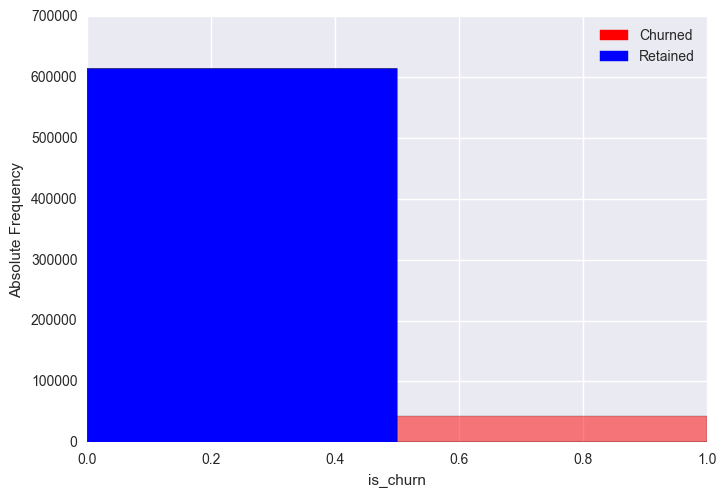

In [32]:
print('\n \n The plot below shows that about',int(usezchurn.shape[0]/useochurn.shape[0]),'times more users are retained than churn.')
bins = np.linspace(0, 1,3)
plt.hist(usezchurn['is_churn'],bins,color='blue')
plt.hist(useochurn['is_churn'],bins,color='red',alpha=0.5)
plt.xlabel('is_churn')
plt.ylabel('Absolute Frequency')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch],loc='upper right')
plt.show()

## Churn users are on average younger

For the hypothesis test below, users with birthday <10 are ignored. Both groups have a large number of users who do note report accurate birthday data. These users are defined by birthday less than 10 or birthday greater than 100 are set to have birthday=0.

The t-test for difference in mean age between churn and retained users gives:
Ttest_indResult(statistic=-27.475080240325589, pvalue=1.7304248757175605e-164)


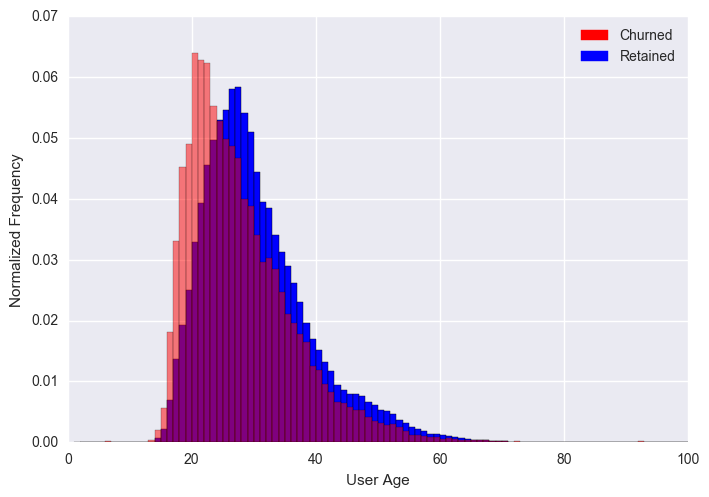

In [39]:
usezbadrm=usezchurn[usezchurn['bd']>0]
useobadrm=useochurn[useochurn['bd']>0]

print("The t-test for difference in mean age between churn and retained users gives:")
print(stats.ttest_ind(useobadrm['bd'], usezbadrm['bd'], axis=0, equal_var=False))

bins = np.linspace(1, 100, 100)
plt.hist(usezchurn['bd'],bins,color='blue',normed=True)
plt.hist(useochurn['bd'],bins,color='red',normed=True,alpha=0.5)
plt.xlabel('User Age')
plt.ylabel('Normalized Frequency')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

## Retained users are more likely to use auto renew than churned users

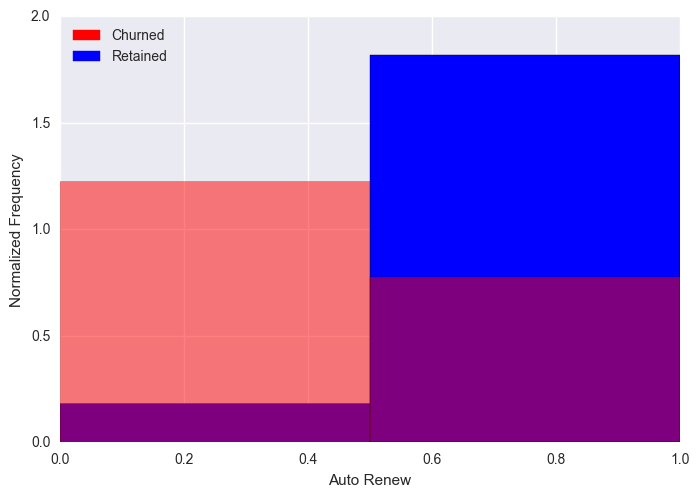

In [49]:
bins = np.linspace(0, 1,3)
plt.hist(usezchurn['is_auto_renew'],bins,color='blue',normed=True)
plt.hist(useochurn['is_auto_renew'],bins,color='red',alpha=0.5,normed=True)
plt.xlabel('Auto Renew')
plt.ylabel('Normalized Frequency')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch],loc='upper left')
plt.show()

## User activity may be useful with proper variable transformation

As a random variable, user activity shows no mean difference for churn and retained users according to a t-test. However, on a log-scale the distributions look somewhat different for high activity. Perhaps this could be useful if the activity variable were suitably transformed?

Note the log-scale of the y-axis


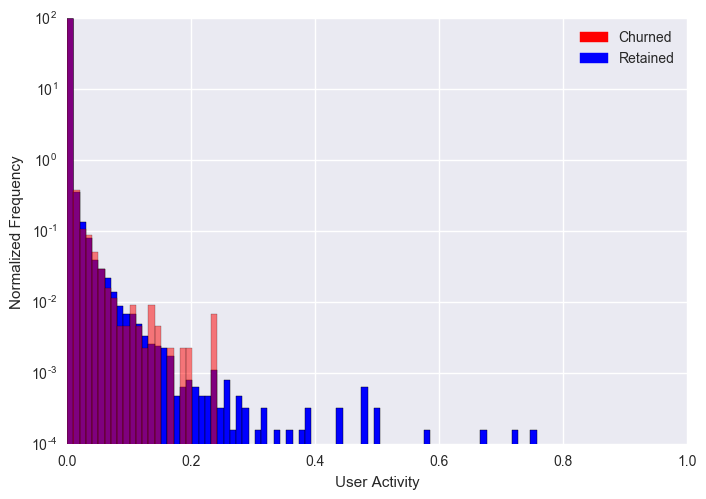

In [91]:
print('Note the log-scale of the y-axis')
bins = np.linspace(0, 1, 100)
plt.hist(np.power(usezchurn['activity'],1),bins,color='blue',normed=True)
plt.hist(np.power(useochurn['activity'],1),bins,color='red',alpha=0.5,normed=True)
plt.xlabel('User Activity')
plt.ylabel('Normalized Frequency')
plt.yscale('log')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

# IV. Model Development

In this section, I will work logistic regression and random forest models for binary classification. I will step through several attempts at model building to demonstrate some important features in building a good model. It should be noted here that this step is realistically premature in the sense that there are many more features that can be calculated.

### Step 1: Split data for 2-fold cross-validation

In [167]:
#Make a validation set
mskval = np.random.rand(len(train)) < 0.75
trainval=train[mskval]
validation=train[~mskval]

#Drop user name and create label data frames (NOTE I AM SWITCHING LABELS TO BE CONSISTENT WITH SKLEARN!)
Xtrain=trainval.drop(['msno','is_churn'],axis=1)
ytrain=(trainval['is_churn']+1)%2
Xval=validation.drop(['msno','is_churn'],axis=1)
yval=(validation['is_churn']+1)%2

Xtrain=np.asarray(Xtrain.as_matrix())
ytrain=np.asarray(ytrain.as_matrix())
Xval=np.asarray(Xval.as_matrix())
yval=np.asarray(yval.as_matrix())

### Step 2: Generate logistic regression and random forest models

In [168]:
#Create a logistic regression model
modelLR=LogisticRegression()
modelLR.fit(Xtrain,ytrain)
predsLR = modelLR.predict_proba(Xval)[:,1]
fprLR, tprLR, _LR = metrics.roc_curve(yval, predsLR)

dfLR = pd.DataFrame(dict(fpr=fprLR, tpr=tprLR))

#Create a random forest model
RFmodel=RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1)
RFmodel.fit(Xtrain,ytrain)
RFpreds = RFmodel.predict_proba(Xval)[:,1]
RFfpr, RFtpr, _ = metrics.roc_curve(yval, RFpreds)
dfRF = pd.DataFrame(dict(fpr=RFfpr, tpr=RFtpr))

In [166]:

print(yval)

[1 1 1 ..., 0 0 0]


### Step 3: Check Model Metrics

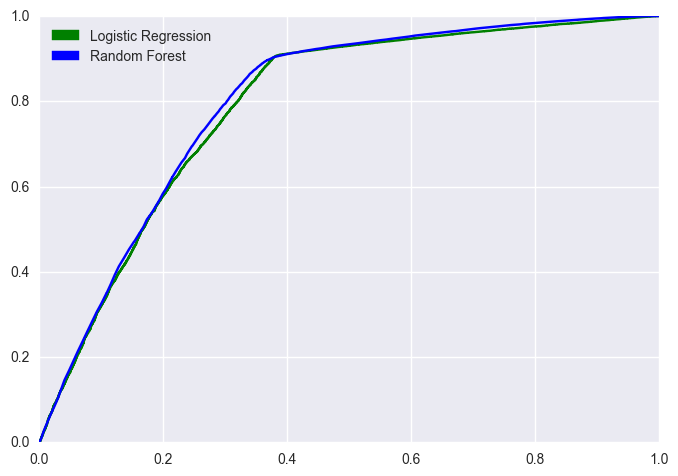

Area under curve for Logistic Regression: 0.790107836882
Log-loss for Logistic Regression: 2.28081616039
Area under curve for Random Forest: 0.798635919713
Log-loss for Random Forest: 2.22359296945


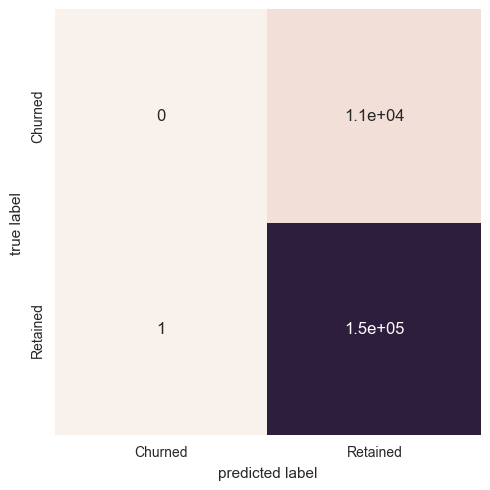

Sensitivity is: 0.999993478757
Specificity is: 0.0
Positive Predictive Value is: 0.933970825593
Negative Predictive Value is: 0.0
Accuracy is: 0.933965137101


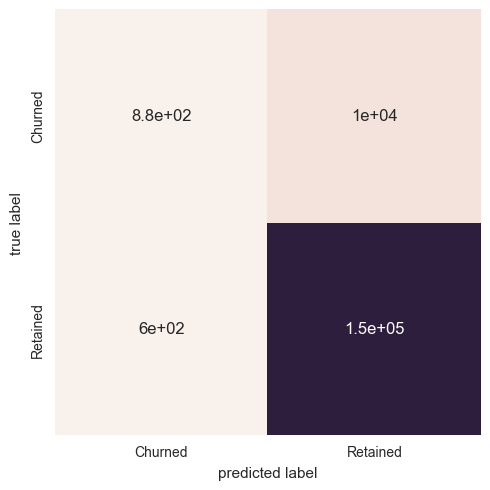

Sensitivity is: 0.996061169259
Specificity is: 0.0807121114288
Positive Predictive Value is: 0.938748793844
Negative Predictive Value is: 0.591615956728
Accuracy is: 0.935621794794


In [174]:
## Define a few metrics
def Sensitivity(confmat):
    val=confmat[1,1]/(confmat[1,1]+confmat[1,0])
    return val

def Specificity(confmat):
    val=confmat[0,0]/(confmat[0,0]+confmat[0,1])
    return val
    
def PPV(confmat):
    val=confmat[1,1]/(confmat[1,1]+confmat[0,1])
    return val

def NPV(confmat):
    val=confmat[0,0]/(confmat[1,0]+confmat[0,0])  
    return val

def Accuracy(confmat):
    val=(confmat[0,0]+confmat[1,1])/(confmat[0,0]+confmat[1,1]+confmat[1,0]+confmat[0,1])  
    return val
    
#Plot the ROC for each
plt.plot(dfLR['fpr'],dfLR['tpr'],color='green');
plt.plot(dfRF['fpr'],dfRF['tpr'],color='blue');
green_patch = mpatches.Patch(color='green', label='Logistic Regression')
blue_patch = mpatches.Patch(color='blue', label='Random Forest')
plt.legend(handles=[green_patch,blue_patch],loc='upper left')
plt.show()

#Take a look at the confusion matrix and calculate a few statistics
Xtest=test.drop(['msno','is_churn'],axis=1)
Ytest=test['is_churn']

yLRpred=modelLR.predict(Xval)

yRFpred=RFmodel.predict(Xval)




aucLR = metrics.auc(fprLR,tprLR)
loglossLR=metrics.log_loss(yval,yLRpred)
aucRF = metrics.auc(RFfpr,RFtpr)
loglossRF=metrics.log_loss(yval,yRFpred)

print("Area under curve for Logistic Regression:", aucLR)
print("Log-loss for Logistic Regression:",loglossLR)
print("Area under curve for Random Forest:", aucRF)
print("Log-loss for Random Forest:",loglossRF)

matLR=confusion_matrix(yval,yLRpred)
seaborn.heatmap(matLR,square=True,annot=True,cbar=False,xticklabels=['Churned','Retained'],yticklabels=['Churned','Retained'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


print("Sensitivity is:",Sensitivity(matLR))

print("Specificity is:",Specificity(matLR))

print("Positive Predictive Value is:",PPV(matLR))

print("Negative Predictive Value is:",NPV(matLR))

print("Accuracy is:",Accuracy(matLR))



matRF=confusion_matrix(yval,yRFpred)
seaborn.heatmap(matRF,square=True,annot=True,cbar=False,xticklabels=['Churned','Retained'],yticklabels=['Churned','Retained'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

print("Sensitivity is:",Sensitivity(matRF))

print("Specificity is:",Specificity(matRF))

print("Positive Predictive Value is:",PPV(matRF))

print("Negative Predictive Value is:",NPV(matRF))

print("Accuracy is:",Accuracy(matRF))

### Step 4: Refine the model

It is important when model building to choose appropriate metrics given the problem at hand. For example, here, due to the population imbalance, resonable accuracy of about 14/15~0.93 (the ratio of retained to total population) can be expected by just saying all users are retained. This is almost exactly the accuracy achieved in both models which is a cause for immediate concern. In the above, random forest performs better than logistic regression. However, neither exhibit particularly good negative predictive value. Below, the two proceedures of oversampling the minority population and undersampling the majority population in the training data are compared. Note that until a model is chosen, the test set is not employed!

#### Oversampling the minority population to get 1:1 ratio

In [175]:
##Oversample to create a more balanced population. Here I will try to get population close to say 1:1.
## I don't oversample the validation set to get more acurate out of sample metrics

##First split into churn and retained
usezchurn=trainval[trainval['is_churn']==0]
useochurn=trainval[trainval['is_churn']==1]

useochurnosamp=useochurn.sample(n=int(usezchurn.shape[0]),replace=True)

trainosamp=useochurnosamp.append(usezchurn)

#Drop user name and create label data frames
Xosamptrain=trainosamp.drop(['msno','is_churn'],axis=1)
yosamptrain=(trainosamp['is_churn']+1)%2
Xosampval=validation.drop(['msno','is_churn'],axis=1)
yosampval=(validation['is_churn']+1)%2

Xosamptrain=np.asarray(Xosamptrain.as_matrix())
yosamptrain=np.asarray(yosamptrain.as_matrix())
Xosampval=np.asarray(Xosampval.as_matrix())
yosampval=np.asarray(yosampval.as_matrix())

#### Generate models

In [176]:
#Create a logistic regression model
osampmodelLR=LogisticRegression()
osampmodelLR.fit(Xosamptrain,yosamptrain)
osamppredsLR = osampmodelLR.predict_proba(Xosampval)[:,1]
osampfprLR, osamptprLR, osamp_LR = metrics.roc_curve(yosampval, osamppredsLR)

osampdfLR = pd.DataFrame(dict(fpr=osampfprLR, tpr=osamptprLR))

#Create a random forest model
osampmodel=RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1)
osampmodel.fit(Xosamptrain,yosamptrain)
osampRFpreds = osampmodel.predict_proba(Xosampval)[:,1]
osampRFfpr, osampRFtpr, osampRF_ = metrics.roc_curve(yosampval, osampRFpreds)

osampRFdf = pd.DataFrame(dict(fpr=osampRFfpr, tpr=osampRFtpr))

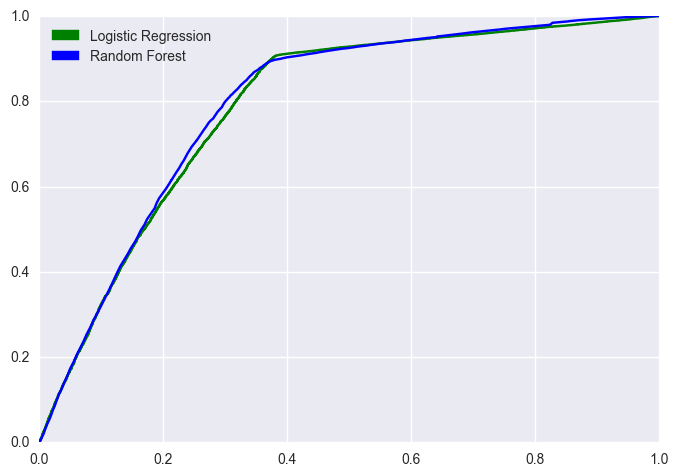

Area under curve for Logistic Regression: 0.787810010971
Log-loss for Logistic Regression: 3.8467311286
Area under curve for Random Forest: 0.793922195256
Log-loss for Random Forest: 2.34875587155


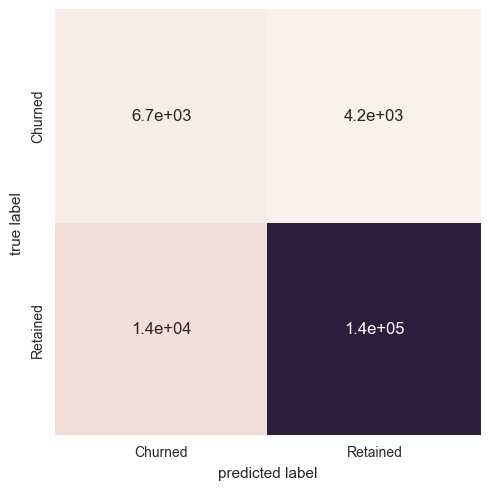

Sensitivity is: 0.907926570804
Specificity is: 0.615625864773
Positive Predictive Value is: 0.970940004045
Negative Predictive Value is: 0.320973404511
Accuracy is: 0.888626314058


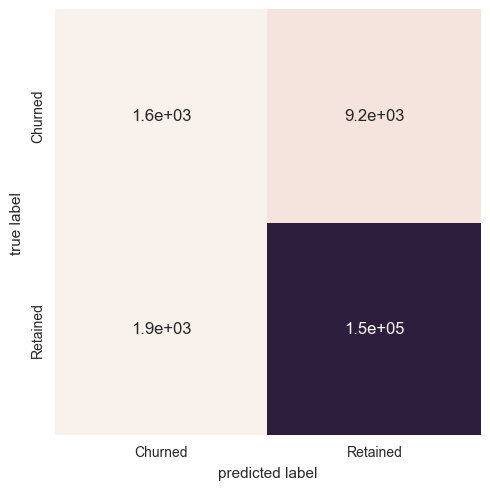

Sensitivity is: 0.987485734781
Specificity is: 0.147126648833
Positive Predictive Value is: 0.942454192392
Negative Predictive Value is: 0.45389869095
Accuracy is: 0.93199785609


In [178]:
#Plot the ROC for each
plt.plot(osampdfLR['fpr'],osampdfLR['tpr'],color='green');
plt.plot(osampRFdf['fpr'],osampRFdf['tpr'],color='blue');
green_patch = mpatches.Patch(color='green', label='Logistic Regression')
blue_patch = mpatches.Patch(color='blue', label='Random Forest')
plt.legend(handles=[green_patch,blue_patch],loc='upper left')
plt.show()

yoLRpred=osampmodelLR.predict(Xosampval)

yoRFpred=osampmodel.predict(Xosampval)


oaucLR = metrics.auc(osampfprLR,osamptprLR)
ologlossLR=metrics.log_loss(yosampval,yoLRpred)
oaucRF = metrics.auc(osampRFfpr,osampRFtpr)
ologlossRF=metrics.log_loss(yosampval,yoRFpred)

print("Area under curve for Logistic Regression:", oaucLR)
print("Log-loss for Logistic Regression:",ologlossLR)
print("Area under curve for Random Forest:", oaucRF)
print("Log-loss for Random Forest:",ologlossRF)


matoLR=confusion_matrix(yosampval,yoLRpred)
seaborn.heatmap(matoLR,square=True,annot=True,cbar=False,xticklabels=['Churned','Retained'],yticklabels=['Churned','Retained'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print("Sensitivity is:",Sensitivity(matoLR))

print("Specificity is:",Specificity(matoLR))

print("Positive Predictive Value is:",PPV(matoLR))

print("Negative Predictive Value is:",NPV(matoLR))

print("Accuracy is:",Accuracy(matoLR))



matoRF=confusion_matrix(yosampval,yoRFpred)
seaborn.heatmap(matoRF,square=True,annot=True,cbar=False,xticklabels=['Churned','Retained'],yticklabels=['Churned','Retained'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

print("Sensitivity is:",Sensitivity(matoRF))

print("Specificity is:",Specificity(matoRF))

print("Positive Predictive Value is:",PPV(matoRF))

print("Negative Predictive Value is:",NPV(matoRF))

print("Accuracy is:",Accuracy(matoRF))

#### Undersample the majority population

In [180]:
##Undersample to create a more balanced population. Here I will try to get population close to say 1:1.
## I don't oversample the validation set to get more acurate out of sample metrics

usezchurnusamp=usezchurn.sample(n=int(useochurn.shape[0]),replace=False)

trainusamp=usezchurnusamp.append(useochurn)

#Drop user name and create label data frames
Xusamptrain=trainusamp.drop(['msno','is_churn'],axis=1)
yusamptrain=(trainusamp['is_churn']+1)%2
Xusampval=validation.drop(['msno','is_churn'],axis=1)
yusampval=(validation['is_churn']+1)%2

Xusamptrain=np.asarray(Xusamptrain.as_matrix())
yusamptrain=np.asarray(yusamptrain.as_matrix())
Xusampval=np.asarray(Xusampval.as_matrix())
yusampval=np.asarray(yusampval.as_matrix())

#### Generate models

In [181]:
#Create a logistic regression model
usampmodelLR=LogisticRegression()
usampmodelLR.fit(Xusamptrain,yusamptrain)
usamppredsLR = usampmodelLR.predict_proba(Xusampval)[:,1]
usampfprLR, usamptprLR, usamp_LR = metrics.roc_curve(yusampval, usamppredsLR)

usampdfLR = pd.DataFrame(dict(fpr=usampfprLR, tpr=usamptprLR))

#Create a random forest model
usampmodel=RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1)
usampmodel.fit(Xusamptrain,yusamptrain)
usampRFpreds = usampmodel.predict_proba(Xusampval)[:,1]
usampRFfpr, usampRFtpr, usampRF_ = metrics.roc_curve(yusampval, usampRFpreds)

usampRFdf = pd.DataFrame(dict(fpr=usampRFfpr, tpr=usampRFtpr))

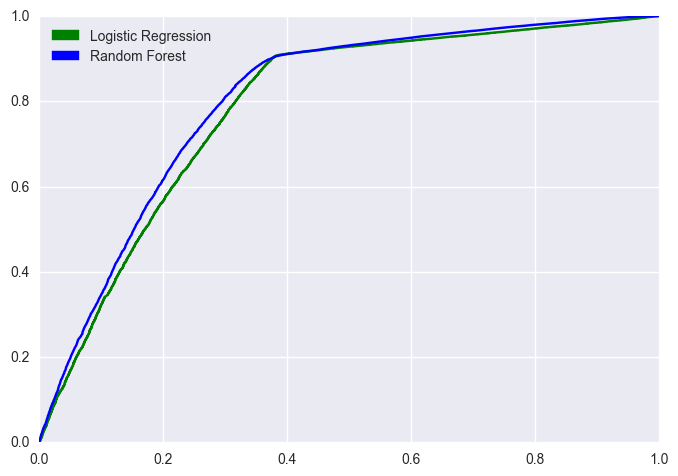

Area under curve for Logistic Regression: 0.787207515434
Log-loss for Logistic Regression: 3.8467311286
Area under curve for Random Forest: 0.804211148126
Log-loss for Random Forest: 2.34875587155


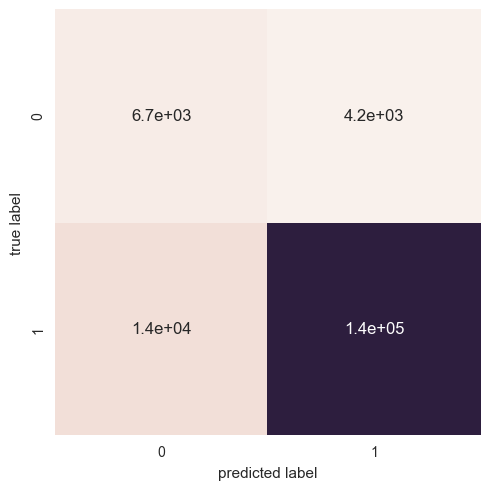

Sensitivity is: 0.907926570804
Specificity is: 0.615625864773
Positive Predictive Value is: 0.970940004045
Negative Predictive Value is: 0.320973404511
Accuracy is: 0.888626314058


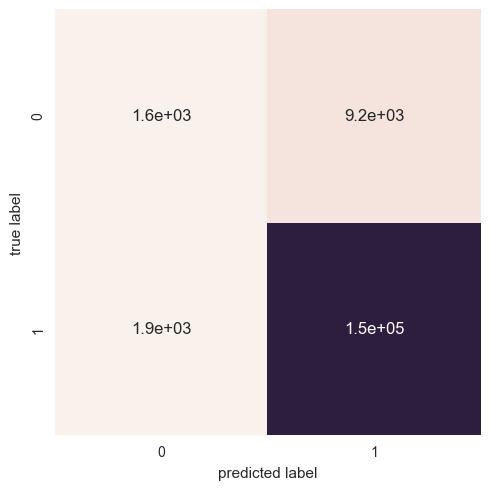

Sensitivity is: 0.987485734781
Specificity is: 0.147126648833
Positive Predictive Value is: 0.942454192392
Negative Predictive Value is: 0.45389869095
Accuracy is: 0.93199785609


In [184]:
#Plot the ROC for each
plt.plot(usampdfLR['fpr'],usampdfLR['tpr'],color='green');
plt.plot(usampRFdf['fpr'],usampRFdf['tpr'],color='blue');
green_patch = mpatches.Patch(color='green', label='Logistic Regression')
blue_patch = mpatches.Patch(color='blue', label='Random Forest')
plt.legend(handles=[green_patch,blue_patch],loc='upper left')
plt.show()

yuLRpred=osampmodelLR.predict(Xusampval)

yuRFpred=osampmodel.predict(Xusampval)


uaucLR = metrics.auc(usampfprLR,usamptprLR)
uloglossLR=metrics.log_loss(yusampval,yuLRpred)
uaucRF = metrics.auc(usampRFfpr,usampRFtpr)
uloglossRF=metrics.log_loss(yusampval,yuRFpred)

print("Area under curve for Logistic Regression:", uaucLR)
print("Log-loss for Logistic Regression:",uloglossLR)
print("Area under curve for Random Forest:", uaucRF)
print("Log-loss for Random Forest:",uloglossRF)


matuLR=confusion_matrix(yosampval,yuLRpred)
seaborn.heatmap(matuLR,square=True,annot=True,cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print("Sensitivity is:",Sensitivity(matuLR))

print("Specificity is:",Specificity(matuLR))

print("Positive Predictive Value is:",PPV(matuLR))

print("Negative Predictive Value is:",NPV(matuLR))

print("Accuracy is:",Accuracy(matuLR))



matuRF=confusion_matrix(yusampval,yuRFpred)
seaborn.heatmap(matuRF,square=True,annot=True,cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

print("Sensitivity is:",Sensitivity(matuRF))

print("Specificity is:",Specificity(matuRF))

print("Positive Predictive Value is:",PPV(matuRF))

print("Negative Predictive Value is:",NPV(matuRF))

print("Accuracy is:",Accuracy(matuRF))

# Conclusion and Outlook

Currently the model accuracy is consistent with efffectively all users being classified as retained. While in some cases, the model gives an estimated Negative predictive value of ~0.5, this is not very good. However, the poor performance of the model is likely first and foremost due to a lack of features in the training data. The next step proposed is to calculate significantly more features for use in training the model. Population imbalance will likely remain an issue, and the methods of over and undersampling discussed will be revisited after updating the trainging set with additional features. In addition, more data has recently become available, and may improve model accuracy. This data will be incorporated after the next round of feature engineering.  